In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load the data
train_data = pd.read_csv('/Users/nadaalqabbani/Documents/GitHub/Riyadh-Electric-Load-forecasting/data/train_data.csv')
test_data = pd.read_csv('/Users/nadaalqabbani/Documents/GitHub/Riyadh-Electric-Load-forecasting/data/test_data.csv')

# Convert 'date' to datetime and set as index
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Convert 'preciptype' column to numeric (1 for 'rain', 0 for not 'rain')
train_data['preciptype'] = train_data['preciptype'].apply(lambda x: 1 if x == 'rain' else 0)
test_data['preciptype'] = test_data['preciptype'].apply(lambda x: 1 if x == 'rain' else 0)

# Handle missing values
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())
test_data[numeric_columns] = test_data[numeric_columns].fillna(test_data[numeric_columns].median())

# Separate features and target
X_train = train_data.drop(columns=['electric_load'])
y_train = train_data['electric_load']
X_test = test_data.drop(columns=['electric_load'])
y_test = test_data['electric_load']

# Normalize features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Normalize target
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Function to create sequences for the model
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i-look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Define the look_back period (e.g., 4 quarters of an hour)
look_back = 12

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, look_back)


/Users/nadaalqabbani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Build the LSTM + GRU model
model = Sequential()
model.add(Input(shape=(look_back, X_train_seq.shape[2])))

# LSTM Layer
model.add(Bidirectional(LSTM(units=30, return_sequences=True, kernel_initializer='he_normal')))
model.add(Dropout(0.3))

# GRU Layer
model.add(Bidirectional(GRU(units=30, return_sequences=False, kernel_initializer='he_normal')))
model.add(Dropout(0.3))

model.add(Dense(units=15))
model.add(Dense(units=1))

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 60)         │        11,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60)             │        16,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,251 (114.26 KB)

 Trainable params: 29,251 (114.26 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=40, batch_size=32, validation_split=0.2, shuffle=False, callbacks=callbacks)


Epoch 1/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.0424 - val_loss: 0.0417 - learning_rate: 1.0000e-04
Epoch 2/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.0042 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 3/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.0028 - val_loss: 0.0105 - learning_rate: 1.0000e-04
Epoch 4/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.0024 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 5/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 0.0023 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 6/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.0022 - val_loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 7/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 0.0021 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 8/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - loss: 0.0021 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 9/40
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 0

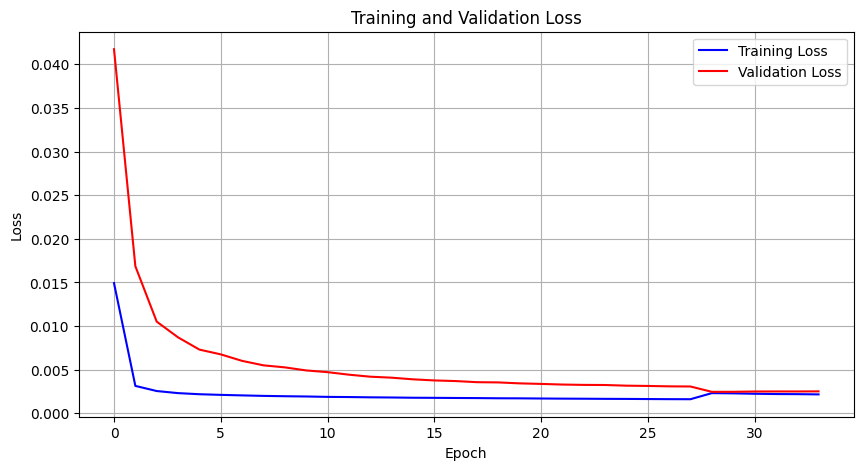

In [4]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Evaluate the model
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Model Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_seq)

# Inverse transform the predictions
predictions = target_scaler.inverse_transform(predictions)
y_test_actual = target_scaler.inverse_transform(y_test_seq)

# Compare predictions with actual values
for i in range(10):
    print(f'Actual: {y_test_actual[i]}, Predicted: {predictions[i]}')


931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032
Model Loss: 0.005384049378335476
931/931 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Actual: [11389.06152344], Predicted: [11635.3545]
Actual: [11403.15429688], Predicted: [11526.344]
Actual: [11286.78320312], Predicted: [11419.92]
Actual: [11286.12597656], Predicted: [11317.071]
Actual: [11193.20898438], Predicted: [11218.743]
Actual: [11105.47265625], Predicted: [11125.816]
Actual: [11075.578125], Predicted: [11039.102]
Actual: [11006.87597656], Predicted: [10959.343]
Actual: [10937.70507812], Predicted: [10887.2295]
Actual: [10916.80273438], Predicted: [10823.431]


In [6]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = mean_absolute_percentage_error(y_test_actual, predictions)

# Print metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAPE'],
    'Value': [rmse, mape * 100]
})
print(metrics_df)

  Metric        Value
0   RMSE  1345.812576
1   MAPE     9.087532


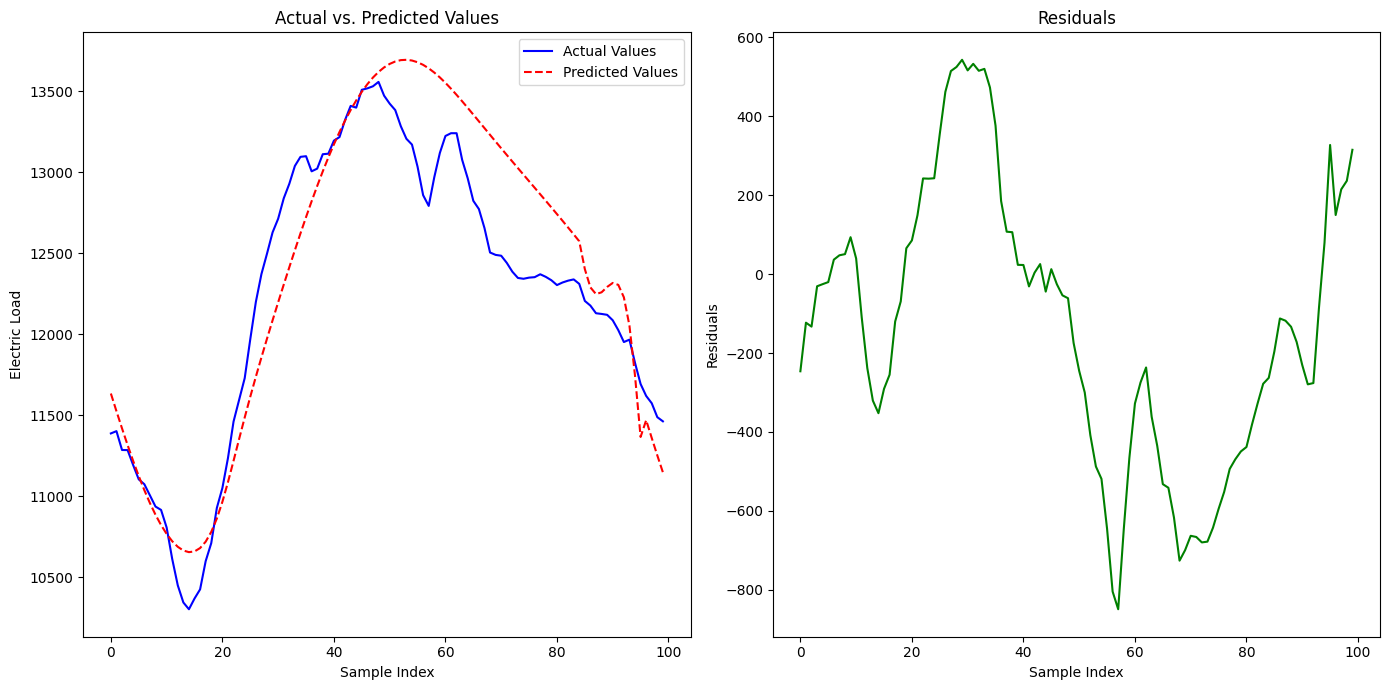

In [7]:
# Plot actual vs. predicted values and residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot actual vs. predicted values
plt.subplot(1, 2, 1)
plt.plot(y_test_actual[:100], label='Actual Values', color='blue')
plt.plot(predictions[:100], label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Electric Load')
plt.legend()

# Plot residuals
residuals = y_test_actual - predictions
plt.subplot(1, 2, 2)
plt.plot(residuals[:100], color='green')
plt.title('Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
